In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import logging
from tqdm import tqdm

import numpy as np
from scipy import interpolate
from astropy.io import fits
import jax.numpy as jnp

sys.path.append(os.environ['DM21CM_DIR'])
import dm21cm.physics as phys
from dm21cm.utils import load_h5_dict
from dm21cm.dm_params import DMParams
from dm21cm.evolve import get_z_edges
from dm21cm.interpolators_jax import BatchInterpolator

sys.path.append(os.environ['DH_DIR'])
import darkhistory
from darkhistory.spec.spectrum import Spectrum
from darkhistory.main import evolve as dh_evolve
from darkhistory.config import load_data as dh_load_data
print(darkhistory.__version__)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


1.0.0-dm21cm.0


In [9]:
tf_name = 'zf01'
abscs = load_h5_dict(os.environ['DM21CM_DIR'] + f"/data/abscissas/abscs_{tf_name}.h5")

In [6]:
rs = 38.71318413405634
xe = 0.1

In [4]:
abscs['x']

array([1.0000e-05, 1.0000e-04, 1.0000e-03, 1.0000e-02, 1.0000e-01,
       3.0000e-01, 7.0000e-01, 9.0000e-01, 9.9900e-01, 9.9999e-01])

## DH_run

In [7]:
dep_tf = dh_load_data(
    'dep_tf',
    verbose=1,
    prefix="/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_zf01",
    force_reload=True
)

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_zf01
    for propagating photons...  

 Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******


In [10]:
dh_soln = dh_evolve(
    DM_process='decay', mDM=1.2e10, lifetime=1e24, primary='phot_delta',
    start_rs=rs, end_rs=rs/1.01,
    coarsen_factor=12, backreaction=True,
    init_cond=(xe, phys.chi*xe, 10*phys.kB),
    use_tqdm=False, verbose=1,
    cross_check_21cmfast=True,
    cross_check_21cmfast_tf_version=tf_name,
    debug_bath_point_injection=True,
    #debug_use_tf_dt=True,
)

Loading time: 0.000 s
Initialization time: 0.020 s
rs=38.71318413405634, bath point injection
(array([407, 410]),)
bath energy 44423.86333850733
eng per inj 12000000000.0
inj_per_Bavg 1.4093865081752076e-11
inj eng 0.16912638098102492
Main loop time: 0.097 s


In [11]:
f_dh = np.array([dh_soln['f']['low'][k] + dh_soln['f']['high'][k] for k in dh_soln['f']['low']])
f_dh = f_dh[:,0]

In [12]:
f_dh

array([5.88871345e-04, 5.83532064e-06, 4.68194212e-04, 2.66565270e-03,
       2.41026549e-05])

## 21 run

In [13]:
from dm21cm.evolve import evolve
import py21cmfast as p21c
from astropy.cosmology import Planck18

In [15]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 1.2e10,
    lifetime = 1e24,
)

return_dict = evolve(
    run_name = 'dhc_test',
    z_start = 46.2, # 38.2
    z_end = 4.96266792, # 4.96266792
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = 'zf01',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            SIGMA_8 = 1e-8, # Planck18.meta['sigma8']
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = ['uniform_xray'],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='../run_info',
    debug_dhc_delta_fixed=True,
    #debug_use_tf_dt=True,
    debug_no_bath=True,
    debug_bath_point_injection=True,
    debug_break_after_z=45.,
    debug_dhc_DH_xe_func=lambda z : xe,
)

INFO:root:Using 21cmFAST version 0.1.dev1585+ge3818c7.d20231008
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


get_init_cond 74.6501517924096 0.0009509455728424983


i_z=0/206 z=45.77


This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.576974e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.576974e+01 E_tot_ave = 0.000000e+00
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.530668e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.530668e+01 E_tot_ave = 0.000000e+00


i_z=1/206 z=45.31


bath energy 44423.69421212635
eng per inj 12000000000.0
inj_per_Bavg 1.0762617e-11
inj eng 0.12915140831792904
(array([407]),)
(array([410]),)


i_z=2/206 z=44.85


This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.484819e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.484819e+01 E_tot_ave = 0.000000e+00
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.439425e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.439425e+01 E_tot_ave = 0.000000e+00
xray: 0.4147 +/- 0.4076 s
bath+dm: 0.0586 +/- 0.0019 s
21cmFAST: 0.3728 +/- 0.0001 s
prep_next: 0.0111 +/- 0.0002 s


In [25]:
# DM21CM:
# WARNING:root:Point injecting bath at z=37.713184
# dt 33860104410955.453 34050802162151.98
# bath energy 44423.695
# eng per inj 10000000000.000002
# inj_per_Bavg 1.7007892e-11
# inj eng 0.17007891622844443

In [26]:
# DarkHistory
# rs=38.71318413405634, bath point injection
# (array([407, 408]),)
# bath energy 44423.864291015205
# eng per inj 10000000000.0
# inj_per_Bavg 1.7007888885729e-11
# inj eng 0.17007888885729

In [27]:
# DM21CM:
# WARNING:root:Point injecting bath at z=45.30667755087399 ---------------------
# dt 25856886555192.566 26728107321173.67
# bath energy 44423.695
# eng per inj 12000000000.0
# inj_per_Bavg 1.1125254e-11
# inj eng 0.1335030523630376
# (array([407]),)
# (array([410]),)

In [28]:
# DH:
# rs=46.30667755087399, bath point injection
# (array([407, 410]),)
# bath energy 44423.827715201114
# eng per inj 12000000000.0
# inj_per_Bavg 1.1125256230453793e-11
# inj eng 0.1335030747654455

In [16]:
run_name = 'dhc_test'
soln = np.load(f"../run_info/{run_name}_records.npy", allow_pickle=True).item()

In [18]:
soln['f_heat']

KeyError: 'f_heat'

In [19]:
f3_dm21cm = np.array([soln['f_ion'][2], soln['f_exc'][2], soln['f_heat'][2]])

KeyError: 'f_ion'

In [32]:
f3_dh = np.array([f_dh[0] + f_dh[1], f_dh[2], f_dh[3]])

In [33]:
1 - f3_dm21cm / f3_dh

array([-0.01319811, -0.01592913, -0.0050066 ])

## compare

NameError: name 'f3_dh' is not defined

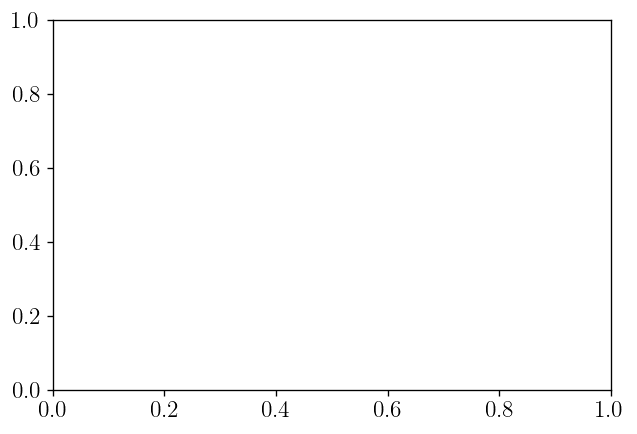

In [17]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

fig, ax = plt.subplots()

ax.plot(f3_dh, label='DarkHistory', color='k')
ax.plot(f3_dm21cm, label='dm21cm', color='r', ls=':')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['ion', 'exc', 'heat'])
ax.set(yscale='log')
#ax.set(ylim=(1e-7,1e-4))
ax.legend();

## A. HED pipeline

In [110]:
# .npy
data_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/zf01/phot"
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
hed_tfgv[8, 3, 6, 429]

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [111]:
# dm21cm tf
tf = np.load(f"{os.environ['DM21CM_DATA_DIR']}/tf/zf01/phot/hed_tf_rxneo.npy")
tf[8, 3, 6, 429]

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [134]:
# dhtf
dhtf = pickle.load(open(f"{os.environ['DH_DATA_DIR']}/../DHdata_v1_1_zf01/highengdep_interp.raw", 'rb'))
dhtf.grid_vals[0][3, 0, 8, 429] * (abscs['dlnz'] / phys.hubble(abscs['rs'][-2]))

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

In [135]:
dhtf.get_val(0.01, 0.9, abscs['rs'][-2])[429] * (abscs['dlnz'] / phys.hubble(abscs['rs'][-2]))

array([11.0582994 ,  8.78602481,  3.48876916, -0.0763134 ])

correct!!